<a href="https://colab.research.google.com/github/yingzibu/a_inhibitor_design/blob/main/examples/experiments/SELFIES_RL_VAE_TEST_08_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -R 'JAK_ML'
! git clone https://github.com/yingzibu/JAK_ML.git --quiet
!rm -R 'JAK-MTATFP'
! git clone https://github.com/Yimeng-Wang/JAK-MTATFP.git --quiet
!rm -R 'selfies'
! git clone https://github.com/aspuru-guzik-group/selfies.git --quiet

! pip install pubchempy --quiet
! pip install rdkit --quiet
! pip install selfies --quiet

rm: cannot remove 'a_inhibitor_design': No such file or directory
rm: cannot remove 'JAK_ML': No such file or directory
rm: cannot remove 'JAK-MTATFP': No such file or directory
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 62.7 MB/s eta 0:00:00


In [78]:
cd /content

/content


In [79]:
!rm -R 'a_inhibitor_design'
! git clone https://github.com/yingzibu/a_inhibitor_design.git --quiet

In [2]:
from tqdm import tqdm
import pandas as pd
from os import walk
import selfies as sf

In [53]:
chembl = '/content/drive/MyDrive/A_DATA/chembl_smi_of_selfie_20.csv'
data = pd.read_csv(chembl)
data.shape, data.head()

((30303, 2),
                        smiles  \
 0              Cc1ccc[nH]c1=O   
 1           C[N+]1(CCO)CCOCC1   
 2  O=[N+]([O-])c1cc(Cl)ccc1Cl   
 3               O=S1(=O)CCCO1   
 4           CCOP(=O)(NCCN)OCC   
 
                                              selfies  
 0     [C][C][=C][C][=C][NH1][C][Ring1][=Branch1][=O]  
 1  [C][N+1][Branch1][Ring2][C][C][O][C][C][O][C][...  
 2  [O][=N+1][Branch1][C][O-1][C][=C][C][Branch1][...  
 3  [O][=S][=Branch1][C][=O][C][C][C][O][Ring1][=B...  
 4  [C][C][O][P][=Branch1][C][=O][Branch1][Branch1...  )

In [80]:
cd /content/a_inhibitor_design/model/VAE_example/

/content/a_inhibitor_design/model/VAE_example


In [57]:
!python chemistry_vae.py

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch: 192,  Batch: 210 / 660,	(loss: 0.6923	| quality: 76.8636 | quality_valid: 76.6218)	ELAPSED TIME: 0.51671
Epoch: 192,  Batch: 240 / 660,	(loss: 0.6861	| quality: 78.7273 | quality_valid: 77.1309)	ELAPSED TIME: 0.51770
Epoch: 192,  Batch: 270 / 660,	(loss: 0.6614	| quality: 78.5000 | quality_valid: 78.1564)	ELAPSED TIME: 0.52468
Epoch: 192,  Batch: 300 / 660,	(loss: 0.6643	| quality: 77.9545 | quality_valid: 77.9000)	ELAPSED TIME: 0.52141
Epoch: 192,  Batch: 330 / 660,	(loss: 0.6478	| quality: 78.9545 | quality_valid: 77.9145)	ELAPSED TIME: 0.54247
Epoch: 192,  Batch: 360 / 660,	(loss: 0.6988	| quality: 77.0909 | quality_valid: 78.4527)	ELAPSED TIME: 0.52329
Epoch: 192,  Batch: 390 / 660,	(loss: 0.6795	| quality: 77.0000 | quality_valid: 78.6073)	ELAPSED TIME: 0.51692
Epoch: 192,  Batch: 420 / 660,	(loss: 0.7367	| quality: 75.6364 | quality_valid: 77.4018)	ELAPSED TIME: 0.51178
Epoch: 192,  Batch: 450 / 660,	(loss: 0.7100	| quality: 75.9545 | quality_val

In [87]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
SELFIES: a robust representation of semantically constrained graphs with an
    example application in chemistry (https://arxiv.org/abs/1905.13741)
    by Mario Krenn, Florian Haese, AkshatKuman Nigam, Pascal Friederich,
    Alan Aspuru-Guzik.

    Variational Autoencoder (VAE) for chemistry
        comparing SMILES and SELFIES representation using reconstruction
        quality, diversity and latent space validity as metrics of
        interest

information:
    ML framework: pytorch
    chemistry framework: RDKit

    get_selfie_and_smiles_encodings_for_dataset
        generate complete encoding (inclusive alphabet) for SMILES and
        SELFIES given a data file

    VAEEncoder
        fully connected, 3 layer neural network - encodes a one-hot
        representation of molecule (in SMILES or SELFIES representation)
        to latent space

    VAEDecoder
        decodes point in latent space using an RNN

    latent_space_quality
        samples points from latent space, decodes them into molecules,
        calculates chemical validity (using RDKit's MolFromSmiles), calculates
        diversity
"""

import os
import sys
import time

import numpy as np
import pandas as pd
import torch
import yaml
from rdkit import rdBase
from rdkit.Chem import MolFromSmiles
from torch import nn

import selfies as sf
# from data_loader import \
#     multiple_selfies_to_hot, multiple_smile_to_hot

rdBase.DisableLog('rdApp.error')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

"""
This file is to encode SMILES and SELFIES into one-hot encodings
"""

import numpy as np

import selfies as sf


def smile_to_hot(smile, largest_smile_len, alphabet):
    """Go from a single smile string to a one-hot encoding.
    """

    char_to_int = dict((c, i) for i, c in enumerate(alphabet))

    # pad with ' '
    smile += ' ' * (largest_smile_len - len(smile))

    # integer encode input smile
    integer_encoded = [char_to_int[char] for char in smile]

    # one hot-encode input smile
    onehot_encoded = list()
    for value in integer_encoded:
        letter = [0 for _ in range(len(alphabet))]
        letter[value] = 1
        onehot_encoded.append(letter)
    return integer_encoded, np.array(onehot_encoded)


def multiple_smile_to_hot(smiles_list, largest_molecule_len, alphabet):
    """Convert a list of smile strings to a one-hot encoding

    Returned shape (num_smiles x len_of_largest_smile x len_smile_encoding)
    """

    hot_list = []
    for s in smiles_list:
        _, onehot_encoded = smile_to_hot(s, largest_molecule_len, alphabet)
        hot_list.append(onehot_encoded)
    return np.array(hot_list)


def selfies_to_hot(selfie, largest_selfie_len, alphabet):
    """Go from a single selfies string to a one-hot encoding.
    """

    symbol_to_int = dict((c, i) for i, c in enumerate(alphabet))

    # pad with [nop]
    selfie += '[nop]' * (largest_selfie_len - sf.len_selfies(selfie))

    # integer encode
    symbol_list = sf.split_selfies(selfie)
    integer_encoded = [symbol_to_int[symbol] for symbol in symbol_list]

    # one hot-encode the integer encoded selfie
    onehot_encoded = list()
    for index in integer_encoded:
        letter = [0] * len(alphabet)
        letter[index] = 1
        onehot_encoded.append(letter)

    return integer_encoded, np.array(onehot_encoded)


def multiple_selfies_to_hot(selfies_list, largest_molecule_len, alphabet):
    """Convert a list of selfies strings to a one-hot encoding
    """

    hot_list = []
    for s in selfies_list:
        _, onehot_encoded = selfies_to_hot(s, largest_molecule_len, alphabet)
        hot_list.append(onehot_encoded)
    return np.array(hot_list)

def _make_dir(directory):
    os.makedirs(directory)


def save_models(encoder, decoder, epoch):
    out_dir = './saved_models/{}'.format(epoch)
    _make_dir(out_dir)
    torch.save(encoder, '{}/E'.format(out_dir))
    torch.save(decoder, '{}/D'.format(out_dir))


class VAEEncoder(nn.Module):

    def __init__(self, in_dimension, layer_1d, layer_2d, layer_3d,
                 latent_dimension):
        """
        Fully Connected layers to encode molecule to latent space
        """
        super(VAEEncoder, self).__init__()
        self.latent_dimension = latent_dimension

        # Reduce dimension up to second last layer of Encoder
        self.encode_nn = nn.Sequential(
            nn.Linear(in_dimension, layer_1d),
            nn.ReLU(),
            nn.Linear(layer_1d, layer_2d),
            nn.ReLU(),
            nn.Linear(layer_2d, layer_3d),
            nn.ReLU()
        )

        # Latent space mean
        self.encode_mu = nn.Linear(layer_3d, latent_dimension)

        # Latent space variance
        self.encode_log_var = nn.Linear(layer_3d, latent_dimension)

    @staticmethod
    def reparameterize(mu, log_var):
        """
        This trick is explained well here:
            https://stats.stackexchange.com/a/16338
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        """
        Pass throught the Encoder
        """
        # Get results of encoder network
        h1 = self.encode_nn(x)

        # latent space
        mu = self.encode_mu(h1)
        log_var = self.encode_log_var(h1)

        # Reparameterize
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var


class VAEDecoder(nn.Module):

    def __init__(self, latent_dimension, gru_stack_size, gru_neurons_num,
                 out_dimension):
        """
        Through Decoder
        """
        super(VAEDecoder, self).__init__()
        self.latent_dimension = latent_dimension
        self.gru_stack_size = gru_stack_size
        self.gru_neurons_num = gru_neurons_num

        # Simple Decoder
        self.decode_RNN = nn.GRU(
            input_size=latent_dimension,
            hidden_size=gru_neurons_num,
            num_layers=gru_stack_size,
            batch_first=False)

        self.decode_FC = nn.Sequential(
            nn.Linear(gru_neurons_num, out_dimension),
        )

    def init_hidden(self, batch_size=1):
        weight = next(self.parameters())
        return weight.new_zeros(self.gru_stack_size, batch_size,
                                self.gru_neurons_num)

    def forward(self, z, hidden):
        """
        A forward pass throught the entire model.
        """

        # Decode
        l1, hidden = self.decode_RNN(z, hidden)
        decoded = self.decode_FC(l1)  # fully connected layer

        return decoded, hidden


def is_correct_smiles(smiles):
    """
    Using RDKit to calculate whether molecule is syntactically and
    semantically valid.
    """
    if smiles == "":
        return False

    try:
        return MolFromSmiles(smiles, sanitize=True) is not None
    except Exception:
        return False


def sample_latent_space(vae_encoder, vae_decoder, sample_len):
    vae_encoder.eval()
    vae_decoder.eval()

    gathered_atoms = []

    fancy_latent_point = torch.randn(1, 1, vae_encoder.latent_dimension,
                                     device=device)
    hidden = vae_decoder.init_hidden()

    # runs over letters from molecules (len=size of largest molecule)
    for _ in range(sample_len):
        out_one_hot, hidden = vae_decoder(fancy_latent_point, hidden)

        out_one_hot = out_one_hot.flatten().detach()
        soft = nn.Softmax(0)
        out_one_hot = soft(out_one_hot)

        out_index = out_one_hot.argmax(0)
        gathered_atoms.append(out_index.data.cpu().tolist())

    vae_encoder.train()
    vae_decoder.train()

    return gathered_atoms


def latent_space_quality(vae_encoder, vae_decoder, type_of_encoding,
                         alphabet, sample_num, sample_len):
    total_correct = 0
    all_correct_molecules = set()
    print(f"latent_space_quality:"
          f" Take {sample_num} samples from the latent space")

    for _ in range(1, sample_num + 1):

        molecule_pre = ''
        for i in sample_latent_space(vae_encoder, vae_decoder, sample_len):
            molecule_pre += alphabet[i]
        molecule = molecule_pre.replace(' ', '')

        if type_of_encoding == 1:  # if SELFIES, decode to SMILES
            molecule = sf.decoder(molecule)

        if is_correct_smiles(molecule):
            total_correct += 1
            all_correct_molecules.add(molecule)

    return total_correct, len(all_correct_molecules)


def quality_in_valid_set(vae_encoder, vae_decoder, data_valid, batch_size):
    data_valid = data_valid[torch.randperm(data_valid.size()[0])]  # shuffle
    num_batches_valid = len(data_valid) // batch_size

    quality_list = []
    for batch_iteration in range(min(25, num_batches_valid)):

        # get batch
        start_idx = batch_iteration * batch_size
        stop_idx = (batch_iteration + 1) * batch_size
        batch = data_valid[start_idx: stop_idx]
        _, trg_len, _ = batch.size()

        inp_flat_one_hot = batch.flatten(start_dim=1)
        latent_points, mus, log_vars = vae_encoder(inp_flat_one_hot)

        latent_points = latent_points.unsqueeze(0)
        hidden = vae_decoder.init_hidden(batch_size=batch_size)
        out_one_hot = torch.zeros_like(batch, device=device)
        for seq_index in range(trg_len):
            out_one_hot_line, hidden = vae_decoder(latent_points, hidden)
            out_one_hot[:, seq_index, :] = out_one_hot_line[0]

        # assess reconstruction quality
        quality = compute_recon_quality(batch, out_one_hot)
        quality_list.append(quality)

    return np.mean(quality_list).item()


def train_model(vae_encoder, vae_decoder,
                data_train, data_valid, num_epochs, batch_size,
                lr_enc, lr_dec, KLD_alpha,
                sample_num, sample_len, alphabet, type_of_encoding):
    """
    Train the Variational Auto-Encoder
    """

    print('num_epochs: ', num_epochs)

    # initialize an instance of the model
    optimizer_encoder = torch.optim.Adam(vae_encoder.parameters(), lr=lr_enc)
    optimizer_decoder = torch.optim.Adam(vae_decoder.parameters(), lr=lr_dec)

    data_train = data_train.clone().detach().to(device)
    num_batches_train = int(len(data_train) / batch_size)

    quality_valid_list = [0, 0, 0, 0]
    folder_names = []
    for epoch in range(num_epochs):

        data_train = data_train[torch.randperm(data_train.size()[0])]

        start = time.time()
        for batch_iteration in range(num_batches_train):  # batch iterator

            # manual batch iterations
            start_idx = batch_iteration * batch_size
            stop_idx = (batch_iteration + 1) * batch_size
            batch = data_train[start_idx: stop_idx]

            # reshaping for efficient parallelization
            inp_flat_one_hot = batch.flatten(start_dim=1)
            latent_points, mus, log_vars = vae_encoder(inp_flat_one_hot)

            # initialization hidden internal state of RNN (RNN has two inputs
            # and two outputs:)
            #    input: latent space & hidden state
            #    output: one-hot encoding of one character of molecule & hidden
            #    state the hidden state acts as the internal memory
            latent_points = latent_points.unsqueeze(0)
            hidden = vae_decoder.init_hidden(batch_size=batch_size)

            # decoding from RNN N times, where N is the length of the largest
            # molecule (all molecules are padded)
            out_one_hot = torch.zeros_like(batch, device=device)
            for seq_index in range(batch.shape[1]):
                out_one_hot_line, hidden = vae_decoder(latent_points, hidden)
                out_one_hot[:, seq_index, :] = out_one_hot_line[0]

            # compute ELBO
            loss = compute_elbo(batch, out_one_hot, mus, log_vars, KLD_alpha)

            # perform back propogation
            optimizer_encoder.zero_grad()
            optimizer_decoder.zero_grad()
            loss.backward(retain_graph=True)
            nn.utils.clip_grad_norm_(vae_decoder.parameters(), 0.5)
            optimizer_encoder.step()
            optimizer_decoder.step()

            if (batch_iteration+1) % int(num_batches_train/3) == 0:
                end = time.time()

                # assess reconstruction quality
                quality_train = compute_recon_quality(batch, out_one_hot)
                quality_valid = quality_in_valid_set(vae_encoder, vae_decoder,
                                                     data_valid, batch_size)

                report = 'Epoch: %d,  Batch: %d / %d,\t(loss: %.4f\t| ' \
                         'quality: %.4f | quality_valid: %.4f)\t' \
                         'ELAPSED TIME: %.5f' \
                         % (epoch, batch_iteration, num_batches_train,
                            loss.item(), quality_train, quality_valid,
                            end - start)
                print(report)
                start = time.time()

        quality_valid = quality_in_valid_set(vae_encoder, vae_decoder,
                                             data_valid, batch_size)
        quality_valid_list.append(quality_valid)

        # only measure validity of reconstruction improved
        quality_increase = len(quality_valid_list) \
                           - np.argmax(quality_valid_list)
        if quality_increase == 1 and quality_valid_list[-1] > 50.:
            corr, unique = latent_space_quality(vae_encoder, vae_decoder,
                                                type_of_encoding, alphabet,
                                                sample_num, sample_len)

            model_path = f'vae/epoch_{epoch}/'
            if not os.path.exists(model_path): os.makedirs(model_path)
            folder_names.append(model_path)
            torch.save(vae_encoder.state_dict(), model_path+'enc.pt')
            torch.save(vae_decoder.state_dict(), model_path+'dec.pt')
            while len(folder_names) > 10:
                try:
                    remove_dir_name = folder_names.pop(0)
                    print('remove dir: ', remove_dir_name)
                    os.rmdir(remove_dir_name)
                except:
                    print(f'error when delete {folder_names[0]}')
        else:
            corr, unique = -1., -1.

        report = 'Validity: %.5f %% | Diversity: %.5f %% | ' \
                 'Reconstruction: %.5f %%' \
                 % (corr * 100. / sample_num, unique * 100. / sample_num,
                    quality_valid)
        print(report)

        with open('results.dat', 'a') as content:
            content.write(report + '\n')

        if quality_valid_list[-1] < 70. and epoch > 200:
            break

        if quality_increase > 20:
            print('Early stopping criteria')
            break


def compute_elbo(x, x_hat, mus, log_vars, KLD_alpha):
    inp = x_hat.reshape(-1, x_hat.shape[2])
    target = x.reshape(-1, x.shape[2]).argmax(1)

    criterion = torch.nn.CrossEntropyLoss()
    recon_loss = criterion(inp, target)
    kld = -0.5 * torch.mean(1. + log_vars - mus.pow(2) - log_vars.exp())

    return recon_loss + KLD_alpha * kld


def compute_recon_quality(x, x_hat):
    x_indices = x.reshape(-1, x.shape[2]).argmax(1)
    x_hat_indices = x_hat.reshape(-1, x_hat.shape[2]).argmax(1)

    differences = 1. - torch.abs(x_hat_indices - x_indices)
    differences = torch.clamp(differences, min=0., max=1.).double()
    quality = 100. * torch.mean(differences)
    quality = quality.detach().cpu().numpy()

    return quality


def get_selfie_and_smiles_encodings_for_dataset(file_path_or_df):
    """
    Returns encoding, alphabet and length of largest molecule in SMILES and
    SELFIES, given a file containing SMILES molecules.

    input:
        csv file with molecules. Column's name must be 'smiles'.
    output:
        - selfies encoding
        - selfies alphabet
        - longest selfies string
        - smiles encoding (equivalent to file content)
        - smiles alphabet (character based)
        - longest smiles string
    """
    if isinstance(file_path_or_df, str):
        file_path = file_path_or_df
        df = pd.read_csv(file_path)
    else: df = file_path_or_df

    smiles_list = np.asanyarray(df.smiles)

    smiles_alphabet = list(set(''.join(smiles_list)))
    smiles_alphabet.append(' ')  # for padding

    largest_smiles_len = len(max(smiles_list, key=len))

    print('--> Translating SMILES to SELFIES...')
    selfies_list = list(map(sf.encoder, smiles_list))

    all_selfies_symbols = sf.get_alphabet_from_selfies(selfies_list)
    all_selfies_symbols.add('[nop]')
    selfies_alphabet = list(all_selfies_symbols)

    largest_selfies_len = max(sf.len_selfies(s) for s in selfies_list)

    print(f'Finished translating {len(selfies_list)} SMILES to SELFIES.')

    return selfies_list, selfies_alphabet, largest_selfies_len, \
           smiles_list, smiles_alphabet, largest_smiles_len


def main(file_name_smiles, type_of_encoding, dynamic_z_dim=False):
    content = open('logfile.dat', 'w')
    content.close()
    content = open('results.dat', 'w')
    content.close()

    if os.path.exists("settings.yml"):
        settings = yaml.safe_load(open("settings.yml", "r"))
    else:
        print("Expected a file settings.yml but didn't find it.")
        return

    print('--> Acquiring data...')
    # type_of_encoding = settings['data']['type_of_encoding']
    file_name_smiles = settings['data']['smiles_file']

    print('Finished acquiring data.')

    if type_of_encoding == 0:
        print('Representation: SMILES')
        _, _, _, encoding_list, encoding_alphabet, largest_molecule_len = \
            get_selfie_and_smiles_encodings_for_dataset(file_name_smiles)

        print('--> Creating one-hot encoding...')
        data = multiple_smile_to_hot(encoding_list, largest_molecule_len,
                                     encoding_alphabet)
        print('Finished creating one-hot encoding.')

    elif type_of_encoding == 1:
        print('Representation: SELFIES')
        encoding_list, encoding_alphabet, largest_molecule_len, _, _, _ = \
            get_selfie_and_smiles_encodings_for_dataset(file_name_smiles)

        print('--> Creating one-hot encoding...')
        data = multiple_selfies_to_hot(encoding_list, largest_molecule_len,
                                       encoding_alphabet)
        print('Finished creating one-hot encoding.')

    else:
        print("type_of_encoding not in {0, 1}.")
        return
    len_compound = data.shape[0]
    len_max_molec = data.shape[1]
    len_alphabet = data.shape[2]
    len_max_mol_one_hot = len_max_molec * len_alphabet

    print(' ')
    print(f"Dataset has {len_compound} compounds, "
          f"Alphabet has {len_alphabet} letters, "
          f"largest molecule is {len_max_molec} letters.")

    data_parameters = settings['data']
    batch_size = data_parameters['batch_size']

    if dynamic_z_dim:
        z_dim = int(len_max_mol_one_hot/300)*100
        settings['encoder']['latent_dimension'] = z_dim
        settings['decoder']['latent_dimension'] = z_dim
        print(f'z_dim {z_dim} is set to ~ 1/3 of in_dim {len_max_mol_one_hot}')
    print(settings['encoder'])
    encoder_parameter = settings['encoder']
    decoder_parameter = settings['decoder']
    training_parameters = settings['training']

    vae_encoder = VAEEncoder(in_dimension=len_max_mol_one_hot,
                             **encoder_parameter).to(device)
    vae_decoder = VAEDecoder(**decoder_parameter,
                             out_dimension=len(encoding_alphabet)).to(device)

    print('*' * 15, ': -->', device)

    data = torch.tensor(data, dtype=torch.float).to(device)

    train_valid_test_size = [0.5, 0.5, 0.0]
    data = data[torch.randperm(data.size()[0])]
    idx_train_val = int(len(data) * train_valid_test_size[0])
    idx_val_test = idx_train_val + int(len(data) * train_valid_test_size[1])

    data_train = data[0:idx_train_val]
    data_valid = data[idx_train_val:idx_val_test]

    print("start training")
    train_model(**training_parameters,
                vae_encoder=vae_encoder,
                vae_decoder=vae_decoder,
                batch_size=batch_size,
                data_train=data_train,
                data_valid=data_valid,
                alphabet=encoding_alphabet,
                type_of_encoding=type_of_encoding,
                sample_len=len_max_molec)

    with open('COMPLETED', 'w') as content:
        content.write('exit code: 0')


# if __name__ == '__main__':
#     try:
#         main()
#     except AttributeError:
#         _, error_message, _ = sys.exc_info()
#         print(error_message)

In [60]:
data_path = '/content/drive/MyDrive/A_DATA/chembl_smi_of_selfie_20.csv'
data = pd.read_csv(data_path)
data.head()

,smiles,selfies
0,Cc1ccc[nH]c1=O,[C][C][=C][C][=C][NH1][C][Ring1][=Branch1][=O]
1,C[N+]1(CCO)CCOCC1,[C][N+1][Branch1][Ring2][C][C][O][C][C][O][C][...
2,O=[N+]([O-])c1cc(Cl)ccc1Cl,[O][=N+1][Branch1][C][O-1][C][=C][C][Branch1][...
3,O=S1(=O)CCCO1,[O][=S][=Branch1][C][=O][C][C][C][O][Ring1][=B...
4,CCOP(=O)(NCCN)OCC,[C][C][O][P][=Branch1][C][=O][Branch1][Branch1...


In [65]:
main(data, type_of_encoding=0)

--> Acquiring data...
Finished acquiring data.
Representation: SMILES
--> Translating SMILES to SELFIES...
Finished translating SMILES to SELFIES.
--> Creating one-hot encoding...
Finished creating one-hot encoding.
 
Alphabet has 37 letters, largest molecule is 45 letters.
*************** : --> cuda
start training
num_epochs:  5000
Epoch: 0,  Batch: 49 / 151,	(loss: 3.4010	| quality: 19.1333 | quality_valid: 20.4524)	ELAPSED TIME: 1.67441
Epoch: 0,  Batch: 99 / 151,	(loss: 2.1245	| quality: 57.5556 | quality_valid: 58.1813)	ELAPSED TIME: 1.62217
Epoch: 0,  Batch: 149 / 151,	(loss: 1.5540	| quality: 60.9111 | quality_valid: 60.3156)	ELAPSED TIME: 1.61150
latent_space_quality: Take 1000 samples from the latent space
Validity: 26.00000 % | Diversity: 4.20000 % | Reconstruction: 59.98578 %
Epoch: 1,  Batch: 49 / 151,	(loss: 1.5550	| quality: 60.6889 | quality_valid: 62.1769)	ELAPSED TIME: 1.68115
Epoch: 1,  Batch: 99 / 151,	(loss: 1.3859	| quality: 63.1111 | quality_valid: 63.7387)	ELAPSE

In [232]:
cd /content/a_inhibitor_design/model/VAE_example

/content/a_inhibitor_design/model/VAE_example


In [ ]:
main(big_df, 1)

--> Acquiring data...
Finished acquiring data.
Representation: SELFIES
--> Translating SMILES to SELFIES...
Finished translating 20681 SMILES to SELFIES.
--> Creating one-hot encoding...
Finished creating one-hot encoding.
 
Dataset has 20681 compounds, Alphabet has 92 letters, largest molecule is 105 letters.
{'layer_1d': 8000, 'layer_2d': 6000, 'layer_3d': 6000, 'latent_dimension': 3000}
*************** : --> cuda
start training
num_epochs:  5000
Epoch: 0,  Batch: 33 / 103,	(loss: 1.4043	| quality: 64.2000 | quality_valid: 64.3196)	ELAPSED TIME: 16.70257
Epoch: 0,  Batch: 67 / 103,	(loss: 1.3024	| quality: 65.5238 | quality_valid: 68.0537)	ELAPSED TIME: 16.99563
Epoch: 0,  Batch: 101 / 103,	(loss: 1.0936	| quality: 71.0286 | quality_valid: 69.4095)	ELAPSED TIME: 16.59841
latent_space_quality: Take 1000 samples from the latent space
Validity: 86.00000 % | Diversity: 49.50000 % | Reconstruction: 71.41219 %
Epoch: 1,  Batch: 33 / 103,	(loss: 1.0484	| quality: 72.0857 | quality_valid: 68

[00:07:37] WARNING: not removing hydrogen atom without neighbors


Validity: 86.50000 % | Diversity: 50.30000 % | Reconstruction: 73.49867 %
Epoch: 3,  Batch: 33 / 103,	(loss: 0.9617	| quality: 73.7714 | quality_valid: 72.5109)	ELAPSED TIME: 16.47450
Epoch: 3,  Batch: 67 / 103,	(loss: 1.0851	| quality: 70.5619 | quality_valid: 73.3547)	ELAPSED TIME: 16.56015
Epoch: 3,  Batch: 101 / 103,	(loss: 0.9984	| quality: 72.7048 | quality_valid: 72.6579)	ELAPSED TIME: 16.55267
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 73.25219 %
Epoch: 4,  Batch: 33 / 103,	(loss: 1.1699	| quality: 68.2857 | quality_valid: 72.4617)	ELAPSED TIME: 16.55406
Epoch: 4,  Batch: 67 / 103,	(loss: 0.9713	| quality: 73.0857 | quality_valid: 72.9661)	ELAPSED TIME: 16.52596
Epoch: 4,  Batch: 101 / 103,	(loss: 1.0127	| quality: 72.4095 | quality_valid: 73.1623)	ELAPSED TIME: 16.54988
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 73.01181 %
Epoch: 5,  Batch: 33 / 103,	(loss: 0.9626	| quality: 73.4000 | quality_valid: 73.3211)	ELAPSED TIME: 16.58999
Epoch:

[00:17:22] WARNING: not removing hydrogen atom without neighbors


Validity: 87.70000 % | Diversity: 50.30000 % | Reconstruction: 73.94362 %
Epoch: 11,  Batch: 33 / 103,	(loss: 0.9621	| quality: 73.3619 | quality_valid: 73.6072)	ELAPSED TIME: 16.52707
Epoch: 11,  Batch: 67 / 103,	(loss: 0.9916	| quality: 72.3333 | quality_valid: 74.3250)	ELAPSED TIME: 16.59193
Epoch: 11,  Batch: 101 / 103,	(loss: 0.8764	| quality: 75.1810 | quality_valid: 73.2404)	ELAPSED TIME: 16.60885
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 73.70248 %
Epoch: 12,  Batch: 33 / 103,	(loss: 0.9259	| quality: 74.1429 | quality_valid: 73.2808)	ELAPSED TIME: 16.60678
Epoch: 12,  Batch: 67 / 103,	(loss: 0.8949	| quality: 74.7333 | quality_valid: 72.9436)	ELAPSED TIME: 16.59939
Epoch: 12,  Batch: 101 / 103,	(loss: 0.8988	| quality: 74.8190 | quality_valid: 72.9893)	ELAPSED TIME: 16.54567
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 73.40648 %
Epoch: 13,  Batch: 33 / 103,	(loss: 0.9748	| quality: 72.9429 | quality_valid: 73.7451)	ELAPSED TIME: 16.58913

[00:26:43] WARNING: not removing hydrogen atom without neighbors


Validity: 88.70000 % | Diversity: 52.20000 % | Reconstruction: 74.02629 %
Epoch: 19,  Batch: 33 / 103,	(loss: 0.9629	| quality: 72.6286 | quality_valid: 74.0034)	ELAPSED TIME: 16.53826
Epoch: 19,  Batch: 67 / 103,	(loss: 0.9456	| quality: 73.4000 | quality_valid: 74.0259)	ELAPSED TIME: 16.59011
Epoch: 19,  Batch: 101 / 103,	(loss: 0.8997	| quality: 74.3524 | quality_valid: 73.7646)	ELAPSED TIME: 16.60516
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 73.60648 %
Epoch: 20,  Batch: 33 / 103,	(loss: 0.9700	| quality: 72.7333 | quality_valid: 73.3044)	ELAPSED TIME: 16.59137
Epoch: 20,  Batch: 67 / 103,	(loss: 0.8784	| quality: 74.7905 | quality_valid: 73.5086)	ELAPSED TIME: 16.59849
Epoch: 20,  Batch: 101 / 103,	(loss: 0.8473	| quality: 76.1429 | quality_valid: 73.0472)	ELAPSED TIME: 16.58849
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 73.51695 %
Epoch: 21,  Batch: 33 / 103,	(loss: 0.9740	| quality: 72.4000 | quality_valid: 73.7432)	ELAPSED TIME: 16.59168

[00:35:38] WARNING: not removing hydrogen atom without neighbors


Validity: 88.20000 % | Diversity: 53.70000 % | Reconstruction: 74.09790 %
Epoch: 26,  Batch: 33 / 103,	(loss: 0.9259	| quality: 73.3619 | quality_valid: 74.0411)	ELAPSED TIME: 16.52998
Epoch: 26,  Batch: 67 / 103,	(loss: 0.8786	| quality: 74.8000 | quality_valid: 73.1623)	ELAPSED TIME: 16.60957
Epoch: 26,  Batch: 101 / 103,	(loss: 1.0024	| quality: 71.3048 | quality_valid: 73.9863)	ELAPSED TIME: 16.61635
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 74.09486 %
Epoch: 27,  Batch: 33 / 103,	(loss: 0.9200	| quality: 73.7238 | quality_valid: 73.9615)	ELAPSED TIME: 16.58400
Epoch: 27,  Batch: 67 / 103,	(loss: 0.9524	| quality: 72.5619 | quality_valid: 73.9185)	ELAPSED TIME: 16.58502
Epoch: 27,  Batch: 101 / 103,	(loss: 0.8125	| quality: 76.4095 | quality_valid: 74.1063)	ELAPSED TIME: 16.56907
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 73.99848 %
Epoch: 28,  Batch: 33 / 103,	(loss: 0.8607	| quality: 75.3619 | quality_valid: 73.7375)	ELAPSED TIME: 16.59254

[00:41:41] WARNING: not removing hydrogen atom without neighbors
[00:41:46] WARNING: not removing hydrogen atom without neighbors


Validity: 89.40000 % | Diversity: 54.30000 % | Reconstruction: 74.12800 %
Epoch: 31,  Batch: 33 / 103,	(loss: 0.9292	| quality: 73.1143 | quality_valid: 74.1867)	ELAPSED TIME: 16.55101
Epoch: 31,  Batch: 67 / 103,	(loss: 0.8426	| quality: 75.2000 | quality_valid: 73.5627)	ELAPSED TIME: 16.54909
Epoch: 31,  Batch: 101 / 103,	(loss: 0.9232	| quality: 72.9905 | quality_valid: 74.1154)	ELAPSED TIME: 16.59066
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 73.88610 %
Epoch: 32,  Batch: 33 / 103,	(loss: 0.9395	| quality: 72.2667 | quality_valid: 73.6088)	ELAPSED TIME: 16.60097
Epoch: 32,  Batch: 67 / 103,	(loss: 0.9423	| quality: 72.5524 | quality_valid: 73.5783)	ELAPSED TIME: 16.59460
Epoch: 32,  Batch: 101 / 103,	(loss: 0.8652	| quality: 74.6762 | quality_valid: 73.9482)	ELAPSED TIME: 16.59657
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 73.92229 %
Epoch: 33,  Batch: 33 / 103,	(loss: 0.8065	| quality: 76.7238 | quality_valid: 73.9924)	ELAPSED TIME: 16.61137

[00:46:25] WARNING: not removing hydrogen atom without neighbors


Validity: 88.40000 % | Diversity: 56.20000 % | Reconstruction: 74.64381 %
Epoch: 35,  Batch: 33 / 103,	(loss: 0.8751	| quality: 74.1143 | quality_valid: 74.1756)	ELAPSED TIME: 16.52054
Epoch: 35,  Batch: 67 / 103,	(loss: 0.8699	| quality: 74.1429 | quality_valid: 74.2008)	ELAPSED TIME: 16.63313
Epoch: 35,  Batch: 101 / 103,	(loss: 0.9358	| quality: 72.6571 | quality_valid: 74.1939)	ELAPSED TIME: 16.63488
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 74.40876 %
Epoch: 36,  Batch: 33 / 103,	(loss: 0.8654	| quality: 74.4286 | quality_valid: 73.6838)	ELAPSED TIME: 16.55838
Epoch: 36,  Batch: 67 / 103,	(loss: 0.8608	| quality: 74.6095 | quality_valid: 74.1398)	ELAPSED TIME: 16.54990
Epoch: 36,  Batch: 101 / 103,	(loss: 0.8587	| quality: 74.6190 | quality_valid: 74.0781)	ELAPSED TIME: 16.59152
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 74.25181 %
Epoch: 37,  Batch: 33 / 103,	(loss: 0.9132	| quality: 72.9429 | quality_valid: 73.9318)	ELAPSED TIME: 16.59417

In [ ]:
big_df

In [88]:
! pip install PyTDC --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.5 MB/s eta 0:00:00


In [ ]:
from tdc.single_pred import Tox
data = Tox(name = 'hERG')
split = data.get_split()
split

In [90]:
from tdc.utils import retrieve_label_name_list
label_list = retrieve_label_name_list('herg_central')
label_list

['hERG_at_1uM', 'hERG_at_10uM', 'hERG_inhib']

In [ ]:
from tdc.single_pred import Tox
data_herg = Tox(name = 'herg_central', label_name = label_list[2])
split_herg = data.get_split()
data.label_distribution()
count_data(split_new)
# split_new

from tdc.single_pred import Tox
data_ames = Tox(name = 'AMES')
data.label_distribution()

split_ames = data.get_split()
count_data(split)

Downloading...
100%|██████████| 885k/885k [00:01<00:00, 783kiB/s]
Loading...
Done!


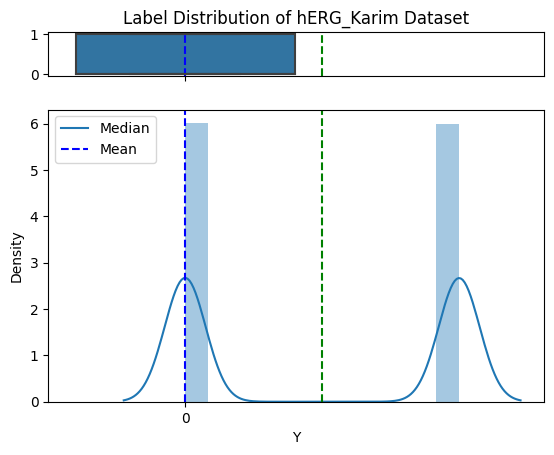

train Y=0 # 4698 Y=1 4714
valid Y=0 # 683 Y=1 661
test Y=0 # 1346 Y=1 1343


In [132]:
# data = Tox(name = 'herg_central', label_name = label_list[2])
data = Tox(name = 'hERG_Karim')
split = data.get_split()
data.label_distribution()
count_data(split)

In [153]:
os.mkdir('/content/drive/MyDrive/A_DATA/AMES_HERG')

In [229]:
cd /content/drive/MyDrive/A_DATA/AMES_HERG/

/content/drive/MyDrive/A_DATA/AMES_HERG


In [228]:
smiles_df = big_df['smiles']
bad_sefs = []
valid_sfs = []
for i, smi in tqdm(enumerate(smiles_df), total=len(smiles_df)):
    try:
        drug_sf = sf.encoder(smi)
        drug_smi = sf.decoder(drug_sf)
        valid_sfs.append(drug_sf)
    except:
        print(i)
        bad_sefs.append(smi)

100%|██████████| 20681/20681 [00:16<00:00, 1230.92it/s]


In [226]:
print(len(big_df))
big_df = big_df.drop(index=17651)
print(len(big_df))

20682
20681


In [230]:
big_df.to_csv('/content/drive/MyDrive/A_DATA/AMES_HERG/all_AMES_HERG_with_property.csv', index=False)

In [158]:
# data = Tox(name = 'hERG_Karim')
# label = 'HERG'

# data = Tox(name = 'AMES')
# label = 'AMES'

# split = data.get_split()
# for i in split.keys():
#     data = pd.DataFrame()
#     data['smiles'] = split[i]['Drug']
#     data[label] = split[i]['Y']
#     # print(i, label)
#     print(data.head())
#     data.to_csv(f"{i}_{label}.csv", index=False)

# for i in split.keys():
#     pd_herg = pd.read_csv(f'{i}_HERG.csv')
#     pd_ames = pd.read_csv(f'{i}_AMES.csv')
#     print(len(pd_herg))
#     # for label in ['HERG', 'AMES']:
#     new = pd_herg.merge(pd_ames, on='smiles', how='outer')
#     print(new.head())
#     print(len(pd_herg), len(pd_ames), len(new), len(new)==len(pd_herg)+len(pd_ames))
#     # new = pd.merge(pd_herg, pd_ames, how="outer")
#     # new = new.fillna(-100, inplace=True)
#     new.to_csv(f'{i}_AMES_HERG.csv', index=False)

for i in split.keys():
    data = pd.read_csv(f'{i}_AMES_HERG.csv')
    d.reset_index(drop=True)
    # print(data.head())
    QED = []
    SA = []
    for j in data['smiles']:


                                              smiles  HERG  AMES
0  COc1cc(N2Cc3ccc(Sc4ccc(F)cc4)nc3C2=O)ccc1OCCN1...   0.0   NaN
1  CCOC(=O)[C@H]1CC[C@@H](N2CC(NC(=O)CNc3nn(C(N)=...   0.0   NaN
2  N[C@@H](Cn1c(=O)cnc2ccc(F)cc21)C1CCC(NCc2ccc3c...   0.0   NaN
3  O=C(NC1COc2cccc(-c3ccnc(CO)c3)c2C1)c1ccc(OCC(F...   0.0   NaN
4      Cc1cc(Nc2cncc(N[C@@H](C)c3ncc(F)cn3)n2)n[nH]1   0.0   NaN
                                              smiles  HERG  AMES
0  CC(C)(C)c1cc(NC(=O)n2ccc3ncc(OC4=NC=N[C@H]5CNC...   0.0   NaN
1  CC(C)OC(=O)C1=CN(C(=O)c2ccc(OCCCN3CCOCC3)cc2)C...   1.0   NaN
2  CS(=O)(=O)C1(c2cc(N3CCOCC3)nc(-c3cccc4[nH]ccc3...   0.0   NaN
3  CS(=O)(=O)Nc1ccc(CCN(CCOc2ccc(NS(C)(=O)=O)cc2)...   1.0   NaN
4  CCN[C@H]1CC[C@@H](c2c[nH]c3ccc(N=C(N)c4cccs4)c...   0.0   NaN
                                              smiles  HERG  AMES
0             COc1nccnc1CC1=C(CCN(C)C)Cc2cc(Cl)ccc21   1.0   NaN
1  O=C(NC1CCN(Cc2ccn(-c3ccc(C(F)(F)F)cc3)c2)CC1)N...   0.0   NaN
2                  Fc1ccc

In [159]:
smiles = data['smiles'].tolist()

In [227]:
big_df.reset_index(drop=True)

,smiles,HERG,AMES,QED,SA,LogP
0,COc1cc(N2Cc3ccc(Sc4ccc(F)cc4)nc3C2=O)ccc1OCCN1...,0.0,NaN,0.452522,2.625327,2.466102
1,CCOC(=O)[C@H]1CC[C@@H](N2CC(NC(=O)CNc3nn(C(N)=...,0.0,NaN,0.487340,2.958167,0.184782
2,N[C@@H](Cn1c(=O)cnc2ccc(F)cc21)C1CCC(NCc2ccc3c...,0.0,NaN,0.507118,3.467794,-0.690659
3,O=C(NC1COc2cccc(-c3ccnc(CO)c3)c2C1)c1ccc(OCC(F...,0.0,NaN,0.587685,3.212980,0.572363
4,Cc1cc(Nc2cncc(N[C@@H](C)c3ncc(F)cn3)n2)n[nH]1,0.0,NaN,0.663672,3.398713,-0.317387
...,...,...,...,...,...,...
20676,O=CCCl,NaN,1.0,0.328271,3.276231,-1.515897
20677,Cc1cccc(C(=O)Cl)c1,NaN,1.0,0.567991,1.700639,1.733858
20678,Cc1ccc2cc3ccccc3cc2c1,NaN,1.0,0.465683,1.558750,3.247855
20679,C/C=C(\C)CCl,NaN,1.0,0.353474,3.281694,-0.290302


In [ ]:
from tdc import Oracle
# cal_qed = Oracle('QED')
# cal_sa = Oracle('SA')
# cal_logp = Oracle('LogP')
for i in split.keys():
    data = pd.read_csv(f'{i}_AMES_HERG.csv')
    data.reset_index(drop=True)

    smiles = data['smiles'].tolist()
    for j in ['QED', 'SA', 'LogP']:
        temp = Oracle(name=j)(smiles)
        data[j] = pd.DataFrame(temp)
    print(data.head())
    data.to_csv(f'{i}_AMES_HERG_with_property.csv', index=False)



                                              smiles  HERG  AMES       QED  \
0  COc1cc(N2Cc3ccc(Sc4ccc(F)cc4)nc3C2=O)ccc1OCCN1...   0.0   NaN  0.452522   
1  CCOC(=O)[C@H]1CC[C@@H](N2CC(NC(=O)CNc3nn(C(N)=...   0.0   NaN  0.487340   
2  N[C@@H](Cn1c(=O)cnc2ccc(F)cc21)C1CCC(NCc2ccc3c...   0.0   NaN  0.507118   
3  O=C(NC1COc2cccc(-c3ccnc(CO)c3)c2C1)c1ccc(OCC(F...   0.0   NaN  0.587685   
4      Cc1cc(Nc2cncc(N[C@@H](C)c3ncc(F)cn3)n2)n[nH]1   0.0   NaN  0.663672   

         SA      LogP  
0  2.625327  2.466102  
1  2.958167  0.184782  
2  3.467794 -0.690659  
3  3.212980  0.572363  
4  3.398713 -0.317387  
                                              smiles  HERG  AMES       QED  \
0  CC(C)(C)c1cc(NC(=O)n2ccc3ncc(OC4=NC=N[C@H]5CNC...   0.0   NaN  0.656733   
1  CC(C)OC(=O)C1=CN(C(=O)c2ccc(OCCCN3CCOCC3)cc2)C...   1.0   NaN  0.317063   
2  CS(=O)(=O)C1(c2cc(N3CCOCC3)nc(-c3cccc4[nH]ccc3...   0.0   NaN  0.726463   
3  CS(=O)(=O)Nc1ccc(CCN(CCOc2ccc(NS(C)(=O)=O)cc2)...   1.0   NaN  0.172084 

In [169]:
cd /content/drive/MyDrive/A_DATA/AMES_HERG/

/content/drive/MyDrive/A_DATA/AMES_HERG


In [170]:
big_df = pd.DataFrame()
for i in split.keys():
    data = pd.read_csv(f'{i}_AMES_HERG_with_property.csv')
    big_df = pd.concat([big_df, data], ignore_index=True)
    print(len(big_df))
big_df.to_csv('all_AMES_HERG_with_property.csv', index=False)

14466
16538
20682


In [205]:
smiles = big_df['smiles'].tolist()
import rdkit
from rdkit import Chem
m = Chem.MolFromSmiles
def remove_ions(smis:list,
    ion_list = ['[K+]', '[Li+]', '[Na+]', '[I-]', '[Cl-]', '[Br-]', 'Cl'],
                print_info = False):
    ions_exist = False
    new_ion_list = []
    for ion in ion_list:
        ion1 = '.'+ ion
        ion2 = ion + '.'
        new_ion_list.append(ion1)
        new_ion_list.append(ion2)

    new_smis = []

    for smi in tqdm(smis):
        ions_exist = False
        new_smi = ''
        for ion in new_ion_list:

            if ion in smi:
                ions_exist = True

                # ions_exist = True
                s = smi.replace(ion, '')
                if print_info == True: print('delete ion: ', ion)
                try:
                    mol = m(s)
                    new_smi = s
                except: new_smi = smi
        if ions_exist == False: new_smi = smi
        new_smis.append(new_smi)
    return new_smis



100%|██████████| 20682/20682 [00:00<00:00, 626085.10it/s]

419
683
729
860
863
1011
1037
1543
1711
1828
1951
2122
2189
2297
2457
2561
2612
2761
2977
3081
3136
3186
3282
3299
3504
3689
3842
3862
3956
4195
4219
4221
4501
4643
4697
4748
4999
5413
5454
5495
5538
5687
5862
5984
6001
6179
6355
6399
6416
6488
6538
6685
6790
6912
7006
7194
7304
7383
7936
7965
8025
8186
8419
8661
8735
14688
15056
15249
15267
15539
15549
15595
15785
16595
16654
16906
16957
17044
17169
17285
17468
17487
17501
17677
17693
17794
18036
18123
18236
18270
18342
18400
18533
18542
18587
18658
18722
18731
18770
18818
18873
18934
18952
19018
19085
19155
0


0

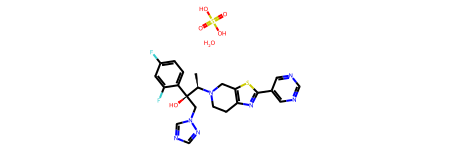

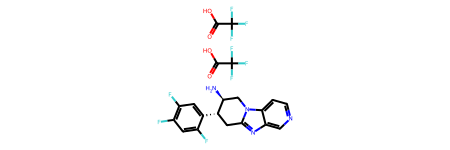

In [199]:
display(m(big_df.iloc[]['smiles']))
display(m(super_strange[0]))

0


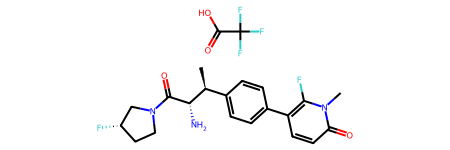

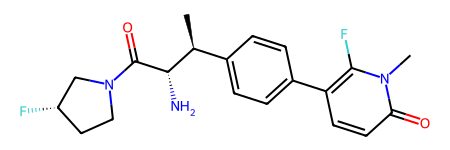

1


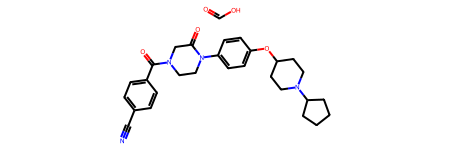

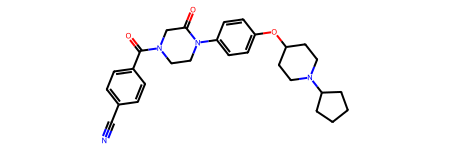

2


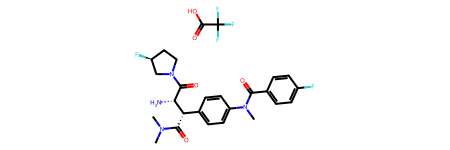

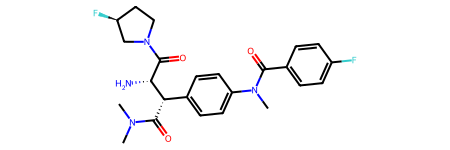

3


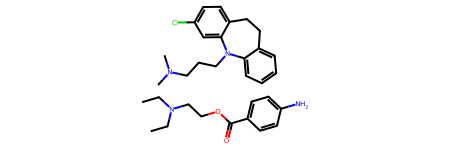

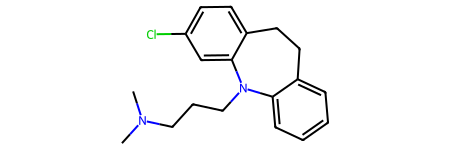

4


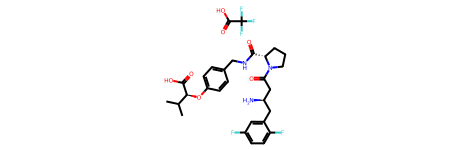

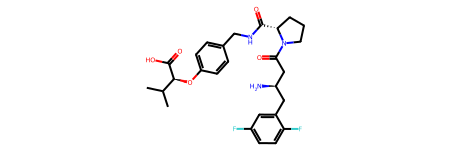

5


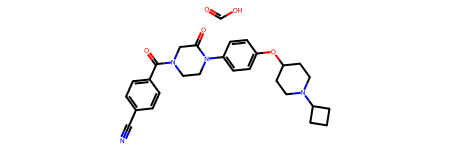

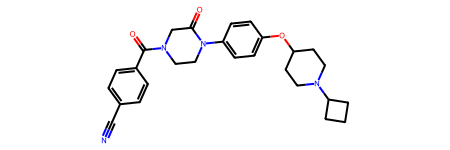

6


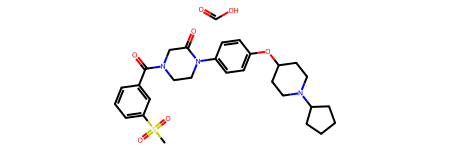

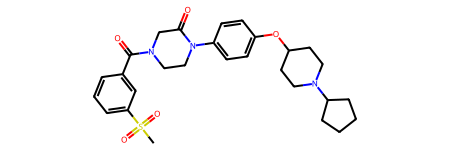

7


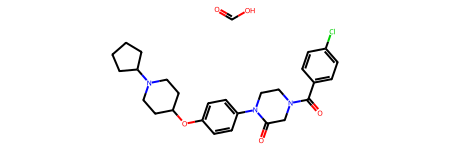

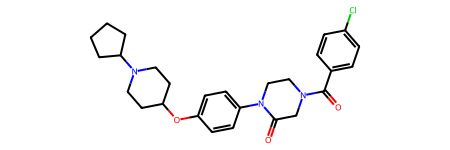

8


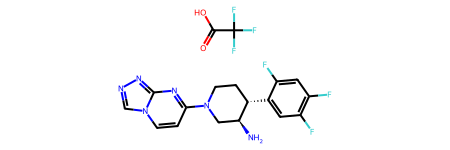

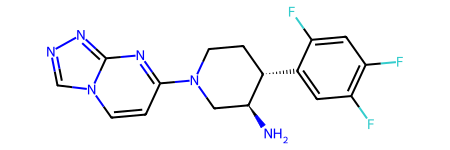

9


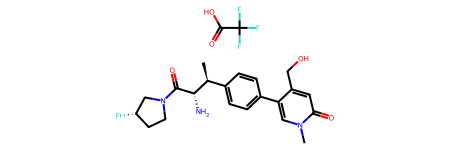

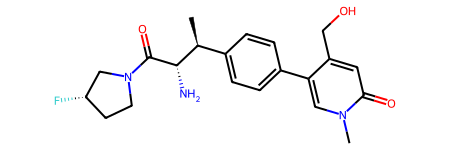

10


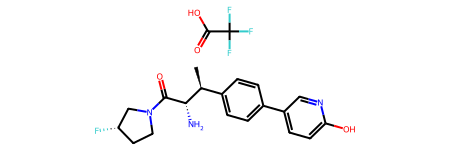

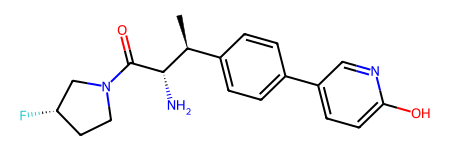

11


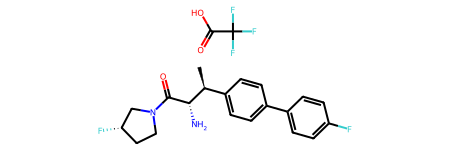

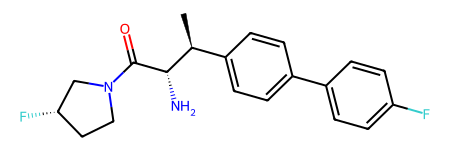

12


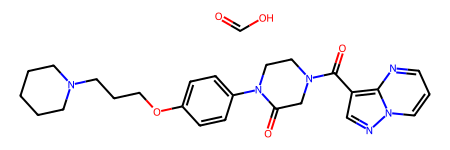

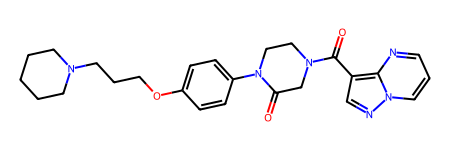

13


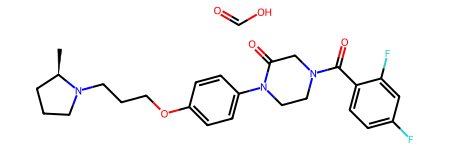

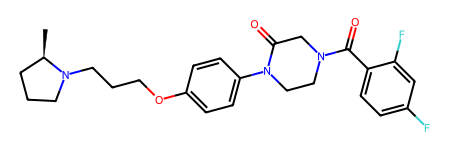

14


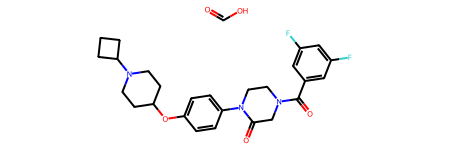

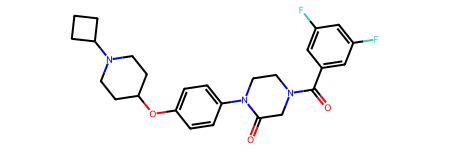

15


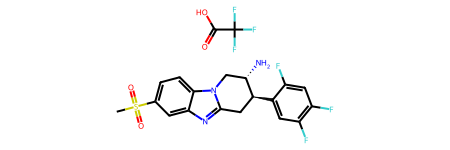

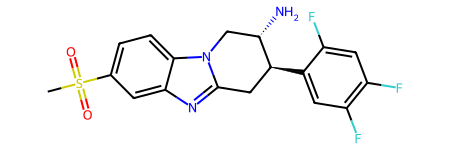

16


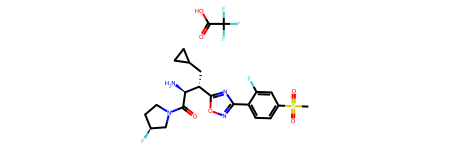

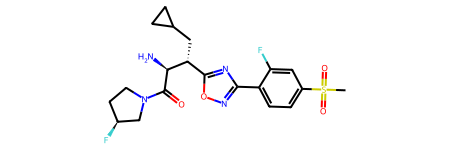

17


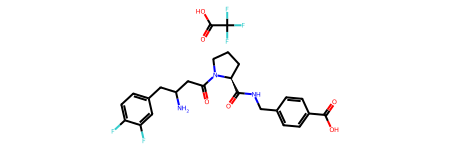

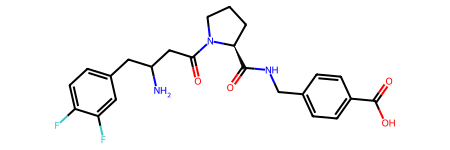

18


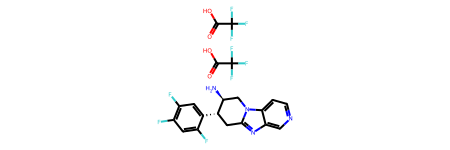

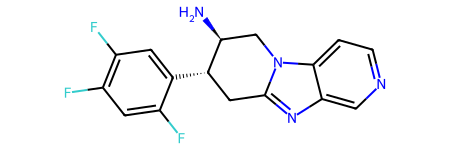

19


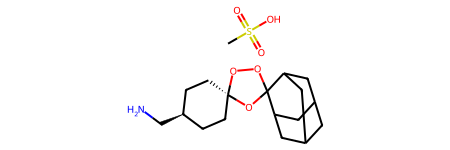

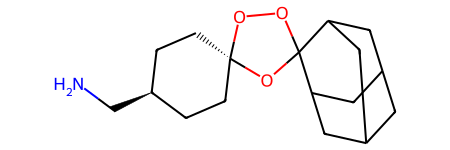

In [213]:
ls

all_AMES_HERG_with_property.csv   train_AMES.csv
data/                             train_AMES_HERG.csv
logfile.dat                       train_AMES_HERG_with_property.csv
oracle/                           train_HERG.csv
results.dat                       valid_AMES.csv
test_AMES.csv                     valid_AMES_HERG.csv
test_AMES_HERG.csv                valid_AMES_HERG_with_property.csv
test_AMES_HERG_with_property.csv  valid_HERG.csv
test_HERG.csv


In [214]:
big_df.iloc[1290]['smiles'] == new_list_new[1290]

big_df['smiles'] = new_list_new
big_df.to_csv('all_AMES_HERG_with_property.csv', index=False)

In [171]:
for ind in len(big_df):


    big_df.drop(index=ind)

,smiles,HERG,AMES,QED,SA,LogP
0,COc1cc(N2Cc3ccc(Sc4ccc(F)cc4)nc3C2=O)ccc1OCCN1...,0.0,NaN,0.452522,2.625327,2.466102
1,CCOC(=O)[C@H]1CC[C@@H](N2CC(NC(=O)CNc3nn(C(N)=...,0.0,NaN,0.487340,2.958167,0.184782
2,N[C@@H](Cn1c(=O)cnc2ccc(F)cc21)C1CCC(NCc2ccc3c...,0.0,NaN,0.507118,3.467794,-0.690659
3,O=C(NC1COc2cccc(-c3ccnc(CO)c3)c2C1)c1ccc(OCC(F...,0.0,NaN,0.587685,3.212980,0.572363
4,Cc1cc(Nc2cncc(N[C@@H](C)c3ncc(F)cn3)n2)n[nH]1,0.0,NaN,0.663672,3.398713,-0.317387
...,...,...,...,...,...,...
20677,O=CCCl,NaN,1.0,0.328271,3.276231,-1.515897
20678,Cc1cccc(C(=O)Cl)c1,NaN,1.0,0.567991,1.700639,1.733858
20679,Cc1ccc2cc3ccccc3cc2c1,NaN,1.0,0.465683,1.558750,3.247855
20680,C/C=C(\C)CCl,NaN,1.0,0.353474,3.281694,-0.290302


In [96]:
from tdc.single_pred import Tox
data = Tox(name = 'hERG_Karim')
split_a_new = data.get_split()
split_a_new['train']

Downloading...
100%|██████████| 885k/885k [00:01<00:00, 790kiB/s]
Loading...
Done!


,Drug_ID,Drug,Y
0,1,COc1cc(N2Cc3ccc(Sc4ccc(F)cc4)nc3C2=O)ccc1OCCN1...,0
1,2,CCOC(=O)[C@H]1CC[C@@H](N2CC(NC(=O)CNc3nn(C(N)=...,0
2,3,N[C@@H](Cn1c(=O)cnc2ccc(F)cc21)C1CCC(NCc2ccc3c...,0
3,4,O=C(NC1COc2cccc(-c3ccnc(CO)c3)c2C1)c1ccc(OCC(F...,0
4,5,Cc1cc(Nc2cncc(N[C@@H](C)c3ncc(F)cn3)n2)n[nH]1,0
...,...,...,...
9407,13437,O=c1cc(-c2ccccc2)oc2cc(O)c(O)c(O)c12,0
9408,13438,CN(C)c1ccc2cc(C(=O)N[C@@H](CCCNC(=N)CCl)C(=O)N...,0
9409,13439,CCN(CC)CCCCNc1ncc2c(n1)N(C)C(=O)N(c1c(Cl)c(OC)...,0
9410,13441,Cc1cccc(-c2n[nH]cc2-c2ccc3ncccc3n2)n1,0


In [107]:
def count_data(split_new:dict):
    for i in split_new.keys():
        print(i, 'Y=0 #', len(split_new[i][split_new[i]['Y']==0]),
              'Y=1', len(split_new[i][split_new[i]['Y']==1]))

In [108]:
for s in [split, split_new, split_a_new]:
    print('*'*20)
    count_data(s)

********************
train Y=0 # 148 Y=1 310
valid Y=0 # 23 Y=1 43
test Y=0 # 33 Y=1 98
********************
train Y=0 # 205125 Y=1 9700
valid Y=0 # 29362 Y=1 1327
test Y=0 # 58662 Y=1 2717
********************
train Y=0 # 4698 Y=1 4714
valid Y=0 # 683 Y=1 661
test Y=0 # 1346 Y=1 1343


In [ ]:
count_data(split)

Found local copy...
Loading...
Done!


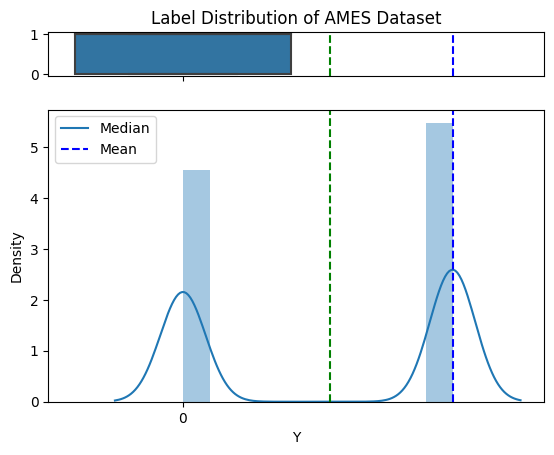

train Y=0 # 2335 Y=1 2759
valid Y=0 # 311 Y=1 417
test Y=0 # 658 Y=1 798


In [110]:
from tdc.single_pred import Tox
data = Tox(name = 'DILI')
split = data.get_split()
count_data(split)

Downloading...
100%|██████████| 26.7k/26.7k [00:00<00:00, 22.4MiB/s]
Loading...
Done!


train Y=0 # 171 Y=1 161
valid Y=0 # 21 Y=1 27
test Y=0 # 47 Y=1 48


In [111]:
from tdc.single_pred import Tox
data = Tox(name = 'Carcinogens_Lagunin')
split = data.get_split()
count_data(split)

Downloading...
100%|██████████| 20.2k/20.2k [00:00<00:00, 90.8kiB/s]
Loading...
Done!


train Y=0 # 154 Y=1 42
valid Y=0 # 22 Y=1 6
test Y=0 # 44 Y=1 12


In [112]:
from tdc.single_pred import Tox
data = Tox(name = 'ClinTox')
split = data.get_split()
count_data(split)
split['train'].head()

Downloading...
100%|██████████| 110k/110k [00:00<00:00, 163kiB/s] 
Loading...
Done!


train Y=0 # 955 Y=1 79
valid Y=0 # 139 Y=1 9
test Y=0 # 272 Y=1 24


,Drug_ID,Drug,Y
0,Drug 0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,0
1,Drug 1,Cl[C@H]1[C@H](Cl)[C@@H](Cl)[C@@H](Cl)[C@H](Cl)...,0
2,Drug 2,O=C([O-])[C@@H](O)[C@@H](O)[C@H](O)[C@@H](O)C(...,0
3,Drug 3,[H]/[NH+]=C(\N)C1=CC(=O)/C(=C\C=c2ccc(=C(N)[NH...,0
4,Drug 4,[H]/[NH+]=C(\N)c1ccc(OCCCCCOc2ccc(/C(N)=[NH+]/...,0


In [121]:
import pandas as pd
names = pd.DataFrame({'names':['bob','frank','bob','bob','bob', 'james','tim','ricardo','mike','mark','joan','joe'],
                      'position':['dev','dev','dev','dev','dev','dev', 'sys','sys','sys','sup','sup','sup']})

info = pd.DataFrame({'names':['joe','mark','tim','frank','joe','bill'],
                     'classification':['thief','thief','good','thief','good','thief']})
what = pd.merge(names, info, how="outer")
what.fillna(-100, inplace=True)

In [116]:
names

,names,position
0,bob,dev
1,frank,dev
2,bob,dev
3,bob,dev
4,bob,dev
5,james,dev
6,tim,sys
7,ricardo,sys
8,mike,sys
9,mark,sup


In [117]:
info

,names,classification
0,joe,thief
1,mark,thief
2,tim,good
3,frank,thief
4,joe,good
5,bill,thief


In [122]:
what

,names,position,classification
0,bob,dev,-100
1,bob,dev,-100
2,bob,dev,-100
3,bob,dev,-100
4,frank,dev,thief
5,james,dev,-100
6,tim,sys,good
7,ricardo,sys,-100
8,mike,sys,-100
9,mark,sup,thief
